# Define the Splits and Used Patients

All or only TIA patients can be selected.  
Then the number of splits (Folds) is defined and the random seed is selected.  
The selection is either stratified by MRS score or by binarized MRS score (0-2 vs. 3-6).

**Note:** All parameters and version names should be defined before running all cells.

### Import Libraries and Install Packages

In [144]:
%matplotlib inline

import os
import h5py
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

### Load Data

In [145]:
#IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
#IMG_DIR = "/home/hezo/stroke_perfusion/data/"
IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/"
#IMG_DIR2 = "/tf/notebooks/kook/data-sets/stroke-lh/"
#OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/data/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/"

In [146]:
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv'

In [147]:
# should only non TIA (transient ischemic attack) patients be included?
only_non_tia = True

with h5py.File(path_img, "r") as h5:
# with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

X_in = np.expand_dims(X_in, axis = 4)

print("image shape in: ", X_in.shape)
print("image min, max, mean, std: ", X_in.min(), X_in.max(), X_in.mean(), X_in.std())


## read tabular data
dat = pd.read_csv(path_tab, sep=",")

print("tabular shape in: ", dat.shape)

image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0
tabular shape in:  (507, 16)


- match patients in tabular and image data (based on patient_id)
- different dimensions, 439 images, 507 clinical data

In [152]:
# get original data

n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
n = len(n)

# match image and tabular data
X = np.zeros((n, X_in.shape[1], X_in.shape[2], X_in.shape[3], X_in.shape[4]))
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in[j]
        p_id[i] = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
p_id = p_id.astype("int")
        
print("X img out shape: ", X.shape)
print("X tab out shape: ", X_tab.shape)
print("Y mrs out shape: ", Y_mrs.shape)

X img out shape:  (407, 128, 128, 28, 1)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)


In [149]:
Y_mrs

array([1., 1., 0., 0., 3., 1., 0., 1., 2., 0., 0., 6., 1., 1., 0., 2., 2.,
       0., 1., 2., 1., 0., 0., 6., 0., 0., 0., 2., 0., 6., 0., 2., 0., 1.,
       0., 3., 0., 4., 1., 2., 3., 0., 1., 0., 6., 0., 3., 2., 0., 0., 0.,
       0., 4., 0., 0., 1., 0., 1., 0., 0., 1., 2., 1., 0., 1., 0., 6., 1.,
       2., 1., 0., 0., 6., 0., 1., 0., 0., 2., 0., 3., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 6., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1., 1., 2., 1., 1., 0.,
       1., 6., 1., 1., 0., 2., 6., 1., 2., 6., 1., 0., 1., 2., 6., 1., 0.,
       0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 2., 1., 2., 1., 6., 0., 0.,
       0., 2., 0., 1., 1., 0., 1., 1., 0., 0., 6., 0., 0., 1., 1., 0., 0.,
       0., 6., 6., 6., 1., 2., 0., 0., 2., 4., 0., 4., 3., 1., 1., 0., 6.,
       6., 4., 0., 6., 0.

- create a binary mRS from the ordinal mRS
- 0,1,2 favorable, 3,4,5,6 unfavorable

In [154]:
## all mrs <= 2 are favorable all higher unfavorable
Y_new = []
for element in Y_mrs:
    if element in [0,1,2]:
        Y_new.append(0)
    else:
        Y_new.append(1)
Y_new = np.array(Y_new)

p_idx = np.arange(0, len(p_id))+1

332 75


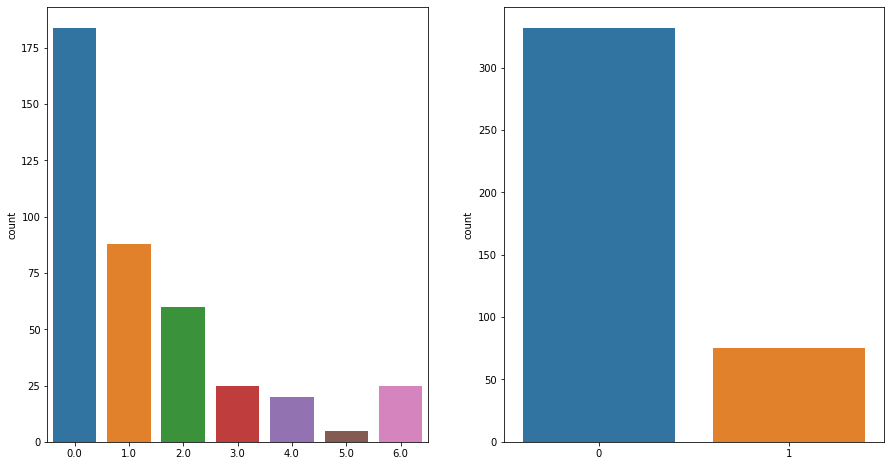

In [155]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.countplot(x = Y_mrs, ax = ax1)
sns.countplot(x = Y_new, ax = ax2)

print(sum(Y_new == 0), sum(Y_new == 1))

Left: Distribution of the MRS score  
Right: Distribution of the binary outcome (MRS>=2)

- somehow get rid of non-TIA patients
- TIA: Transient ischaemic attacks


    TIA Patients: TIAs are temporary episodes of neurological dysfunction caused by a brief interruption in blood flow to a part of the brain. The symptoms of a TIA usually last for a short time, typically less than an hour, and resolve completely without any residual effects.

    Non-TIA Patients: Non-TIA patients may experience more prolonged or permanent neurological symptoms. These symptoms can result from various conditions such as stroke, brain injury, or neurological disorders. The duration of symptoms in non-TIA patients can vary widely depending on the underlying cause.

225 70


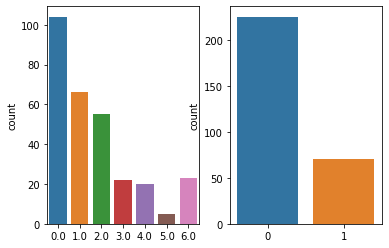

In [11]:
# reduce the data to only non-TIA patients if desired
if only_non_tia:
    p_idx = p_idx[Y_eventtia == 1]
    X_tab = X_tab[Y_eventtia == 1]
    Y_mrs = Y_mrs[Y_eventtia == 1]
    p_id = p_id[Y_eventtia == 1]
    Y_new = Y_new[Y_eventtia == 1]
    Y_eventtia = Y_eventtia[Y_eventtia == 1]
    
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    sns.countplot(x = Y_mrs, ax = ax1)
    sns.countplot(x = Y_new, ax = ax2)
    
    print(sum(Y_new == 0), sum(Y_new == 1))

In [156]:
# Safe ids in pd
id_tab = pd.DataFrame(
    {"p_idx": p_idx,
     "p_id": p_id,
     "mrs": Y_mrs,
     "unfavorable": Y_new
    }
)

## Define Splits

In stratified k-fold cross-validation, the dataset is divided into k subsets (folds) in such a way that each fold maintains the same proportion of the target classes as the entire dataset. This ensures that each fold is representative of the overall class distribution, making the cross-validation process more reliable, especially when dealing with imbalanced datasets.

In [162]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=200)
# 10 Fold V0 random_state 100
# 10 Fold V1 random_state 999
# 10 Fold V2 random_stat3 500
# 10 Fold V3 random_state 200
folds = []
  

for train_index, test_index in skf.split(p_id, Y_new): # 10 Fold sigmoid stratified with Outcome Good/Bad (V0, V2, V3)
# for train_index, test_index in skf.split(p_id, Y_mrs): # 10 Fold sigmoid stratified with Outcome MRS (V1)
    folds.append(p_id[test_index])
    print(sum(Y_new[test_index]))

7
7
8
8
8
8
8
7
7
7


In [158]:
for fold in folds:
    print(len(fold))

41
41
41
41
41
41
41
40
40
40


In [159]:
for i, fold in enumerate(folds):
    id_tab["fold" + str(i)] = "train" 
    
    # increment for val (+5 so that no fold has only 40 in train & test)
    j = i+5
    if j >= len(folds):
        j = j-10

    id_tab.loc[id_tab["p_id"].isin(fold), "fold"+str(i)] = "test"
    id_tab.loc[id_tab["p_id"].isin(folds[j]), "fold"+str(i)] = "val"

In [160]:
id_tab

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9
0,1,1,1.0,0,train,train,train,train,test,train,train,train,train,val
1,2,2,1.0,0,train,train,train,train,val,train,train,train,train,test
2,3,3,0.0,0,train,train,train,train,test,train,train,train,train,val
3,4,5,0.0,0,train,train,test,train,train,train,train,val,train,train
4,5,6,3.0,1,test,train,train,train,train,val,train,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,403,555,0.0,0,train,train,train,val,train,train,train,train,test,train
403,404,556,0.0,0,train,train,train,train,val,train,train,train,train,test
404,405,557,1.0,0,train,train,train,val,train,train,train,train,test,train
405,406,559,1.0,0,train,train,train,test,train,train,train,train,val,train


In [161]:
for i in range(len(folds)):
    print(id_tab["fold"+str(i)].value_counts())

train    325
test      41
val       41
Name: fold0, dtype: int64
train    325
test      41
val       41
Name: fold1, dtype: int64
train    326
test      41
val       40
Name: fold2, dtype: int64
train    326
test      41
val       40
Name: fold3, dtype: int64
train    326
test      41
val       40
Name: fold4, dtype: int64
train    325
test      41
val       41
Name: fold5, dtype: int64
train    325
test      41
val       41
Name: fold6, dtype: int64
train    326
val       41
test      40
Name: fold7, dtype: int64
train    326
val       41
test      40
Name: fold8, dtype: int64
train    326
val       41
test      40
Name: fold9, dtype: int64


## Save Data

Version overview:

- andrea_split: splits and training as in paper 
- 10Fold_sigmoid_V0 (old name: 10Fold_sigmoid): 10 stratifed (with outcome mrs > 2 or mrs <= 2) Folds trained with the last layer beeing activated with sigmoid (5 ensembles per split)
- 10Fold_softmax_V0: same Folds as 10Fold_sigmoid but last layer activated with softmax (5 ensembles per split)
- 10Fold_softmax_V1: new 10 Fold stratified (with mrs) and last layer activated with softmax (10 ensembles per split)
- 10Fold_sigmoid_V1: same Folds as 10Fold_softmax_V1 and last layer activated with sigmoid (10 ensembles per split)
- 10Fold_sigmoid_V2: 10 Fold binary stratified (mrs > or <= 2) other seed than V0, and last layer activated with sigmoid (5 ensembles per split)
- 10Fold_sigmoid_V2f: same as 10Fold_sigmoid_V2 but with flatten Layer
- 10Fold_signoid_V3: 10 Fold binary stratified (mrs > or <= 2) without TIA patients, other seed than V0 and V2 and last layer activated wih sigmoid (5 ensembles per split)

In [163]:
# id_tab.to_csv(OUTPUT_DIR + "10Fold_ids_V0.csv",  index=False)
# id_tab.to_csv(OUTPUT_DIR + "10Fold_ids_V1.csv",  index=False)
# id_tab.to_csv(OUTPUT_DIR + "10Fold_ids_V2.csv",  index=False)
id_tab.to_csv(OUTPUT_DIR + "10Fold_ids_V3.csv",  index=False)

In [164]:
# Is the same for all versions but is generated nonetheless, could als be generated only once
X = X.squeeze()
X = np.float32(X)

np.save(OUTPUT_DIR + "prepocessed_dicom_3d.npy", X)

## Analyze Data

Check distribution of each split.

In [165]:
# id_tab = pd.read_csv(OUTPUT_DIR + "10Fold_ids_V0.csv", sep=",")
# id_tab = pd.read_csv(OUTPUT_DIR + "10Fold_ids_V1.csv", sep=",")
# id_tab = pd.read_csv(OUTPUT_DIR + "10Fold_ids_V2.csv", sep=",")
id_tab = pd.read_csv(OUTPUT_DIR + "10Fold_ids_V3.csv", sep=",")
X = np.load(OUTPUT_DIR + "prepocessed_dicom_3d.npy")

In [166]:
id_tab["unfavorable"].value_counts()

0    332
1     75
Name: unfavorable, dtype: int64

In [167]:
print(X.shape)

(407, 128, 128, 28)


- the following plot just looks at the different folds: see if the proportionality is correct??

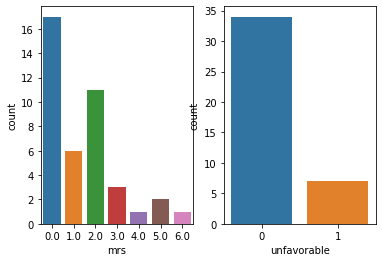

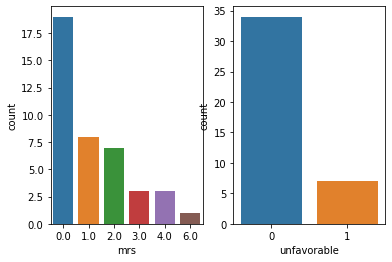

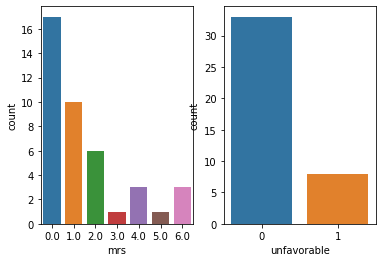

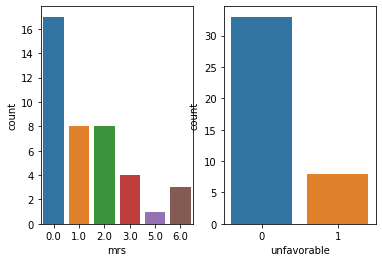

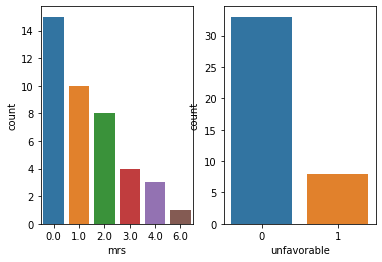

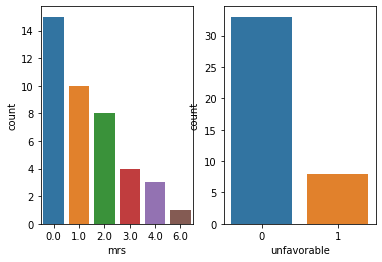

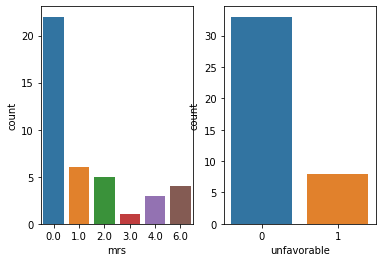

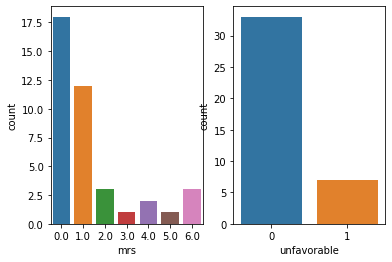

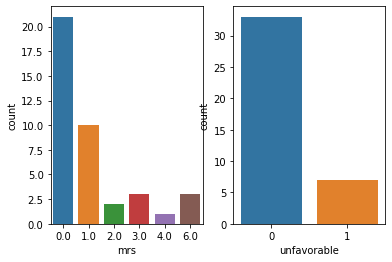

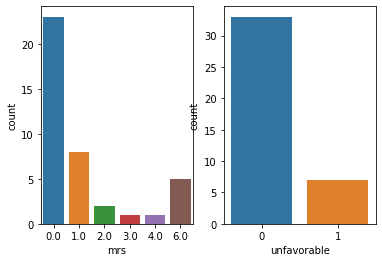

In [168]:
for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1,2)
    sns.countplot(x = id_tab[id_tab["fold"+str(i)]=="test"].mrs, ax = ax1)
    sns.countplot(x = id_tab[id_tab["fold"+str(i)]=="test"].unfavorable, ax = ax2)

### Check Images

Check if images are the same when accessing them.

In [169]:
patient = 460
index1 = id_tab[id_tab.p_id == patient].p_idx.values[0] -1
# index1 = id_tab[id_tab.p_id == patient].index
print(index1)
index2 = np.argwhere(pat == patient).squeeze()
print(index2)

323
346


In [170]:
im1 = X[index1].astype("float64")
im2 = X_in.squeeze()[index2].astype("float64")
np.allclose(im1, im2)

True